# Dual identification of novel phage receptor-binding proteins based on protein domains and machine learning

This notebook serves as the main document of code and analyses for the detection of phage RBPs in published NCBI genomes.

1. **Loading and processing data**: getting MillardLab data and extracting annotated RBPs
2. **Custom HMM domains**: constructing HMMs for enhanced RBP detection based on protein domains
3. **Machine learning models**: constructing a XGBoost classifier to discriminate RBPs from nonRBPs.
4. **Benchmarking against PhANNs**: comparing our methods against PhANNs on hold-out data.

## 0. Libraries

In [17]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import RBPdetect_utils as rbpu
from random import sample
from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, cross_val_predict, train_test_split
from sklearn.metrics import auc, make_scorer, precision_recall_curve, confusion_matrix, f1_score, matthews_corrcoef 
%matplotlib inline

In [18]:
# set directories
pfam_file = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A.hmm'
hmm_path = '/Users/Dimi/hmmer-3.3.1'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'
data_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection'
results_dir = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/33_RESULTS/RBP_detection'
phanns_dir = '/Users/dimi/Documents/GitHub/PhANNs-master/web_server'
#output, err = rbpu.hmmpress_python(hmm_path, pfam_file) # if still need to press Pfam db

## 1. Loading and processing data

1. Get most recent MillardLab data from their GitHub (https://github.com/RyanCook94/inphared): download the tsv file (filtered genomes with information on name, host, family etc) and unfiltered GenBank file of phage genomes (to extract relevant records from) from their website.
2. The functions RBP_collection and RBP_filters will process the MilalrdLab data into two sets of phage RBPs and nonRBPs based on available annotation, and applying several filters to ensure quality (deleting dubious annotations, short proteins, etc...)
3. The final RBP and nonRBP datasets are also timestamped for easy recollection in the future.
4. Finally, the RBPs and nonRBPs are transformed into protein embeddings: cfr protein_embeddings_cloud (too intensive for local computer, so compute with GPU in Kaggle notebooks).

#### Collecting and processing MillardLab data

In [5]:
# load data and collect CDSs
Millard_tsv = data_dir+'/MillardLab_data_2021-12.tsv'
Millard_gb = data_dir+'/MillardLab_genbank_2021-12.gb.txt'
rbpu.RBP_collection(Millard_tsv, Millard_gb, data_dir)

iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000
iteration: 10000
iteration: 11000
iteration: 12000
iteration: 13000
iteration: 14000
iteration: 15000
iteration: 16000
iteration: 17000
iteration: 18000
iteration: 19000
iteration: 20000
iteration: 21000
Wrote RBP and nonRBP databases to directory.


In [16]:
# process & filter collected CDSs
rbps_uf = pd.read_csv(data_dir+'/annotated_RBPs_unfiltered.csv')
nonrbps_uf = pd.read_csv(data_dir+'/annotated_nonRBPs_unfiltered.csv')
print(rbps_uf.shape, nonrbps_uf.shape)
rbpu.RBP_filters(rbps_uf, nonrbps_uf, data_dir, '2022-01')

(16496, 8) (1811032, 8)
(6176, 8) (228315, 8)
Wrote filtered databases to directory.


In [4]:
# load processed data
rbps = pd.read_csv(data_dir+'/annotated_RBPs_2022-01.csv')
nonrbps = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01.csv')

In [5]:
rbps.head()

,phage_id,protein_id,Organism,Host,ProteinName,ProteinSeq,DNASeq,RecordDate
0,OL441337,UFK26514.1,Pseudomonas phage PaP_Se,Pseudomonas aeruginosa,tail fibers protein,MGLEVATYINQLVPTNPTGSDLKSFGDDHLRLIKSAIKNTFPNISQ...,ATGGGTCTTGAGGTCGCAACTTATATTAACCAGTTGGTGCCTACGA...,28-NOV-2021
1,OK625527,UFK26377.1,Klebsiella phage vB_KpnP_ZK1,Klebsiella pneumoniae,tail fibers protein,MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPG...,ATGGAAGTTCAAGGCTCGTTAGGTCGGCAGATACAAGGTATCAGCC...,28-NOV-2021
2,OK562429,UFJ83549.1,Klebsiella phage P929,Klebsiella pneumoniae Kp325,non-contractile tail fiber protein,MAFSWQEQIKPAGTQDIQCDIEYLDKSYIHVYLDGEETTGYTWTSS...,ATGGCGTTCAGCTGGCAAGAACAAATCAAGCCAGCTGGTACCCAGG...,28-NOV-2021
3,OK546191,UFJ83440.1,Acinetobacter phage vB_AbaP_ABWU2101,Acinetobacter baumannii,tailspike protein,MNILRSFTETVVTTPTELFPISFEYDEKYDAVHVFLNDVAVEDLGY...,ATGAATATACTACGCTCATTTACAGAGACAGTGGTGACTACACCTA...,28-NOV-2021
4,MZ675741,UFJ83225.1,Acinetobacter phage Ab1656-2,Acinetobacter baumannii 1656-2,putative tail fiber,MANLVFKFSWDHRPFPYNASQGKRQFMLPFASGIPNLAPNFSQVVG...,ATGGCAAATCTTGTTTTTAAATTTAGTTGGGATCATCGGCCATTCC...,28-NOV-2021


#### Computing embeddings

This is done in the protein_embeddings_cloud notebook on Kaggle, utilizing a GPU for speedup.

## 2. Constructing custom RBP domain HMMs

#### Detect known Pfam domains

In [6]:
# get the data except for the last 3 months (to test on later)
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps['RecordDate']) if any(x in date for x in months)]
rbps_upto2021 = rbps.drop(to_delete_rbps)
rbps_upto2021 = rbps_upto2021.reset_index(drop=True)

In [6]:
# define known Pfam RBP domains to detect
N_blocks_pfam = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
                 'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
                 'DUF2163', 'Phage_fiber_2']
C_blocks_pfam = ['Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
                 'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
                 'gp12-short_mid', 'Collar', 'Peptidase_S74','Phage_fiber_C', 'S_tail_recep_bd', 
                 'CBM_4_9', 'DUF1983', 'DUF3672']

In [7]:
# run detection (first press database if not done already)
#output, err = rbpu.hmmpress_python(hmm_path, pfam_file)
detected_rbps = rbpu.RBPdetect_domains(hmm_path, pfam_file, rbps_upto2021['DNASeq'], rbps_upto2021['protein_id'],
                                       N_blocks=N_blocks_pfam, C_blocks=C_blocks_pfam, detect_others=False)

Scanning the genes:   0%|          | 0/4189 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [8]:
detected_rbps

,identifier,DNASeq,N_blocks,C_blocks,N_ranges,C_ranges
0,QYC51048.1,ATGAGTAACAATACAATCAACCACGTAAGTGATAAATCCATTTACG...,[],[Collar],[],"[(314, 369)]"
1,QYC51112.1,ATGGCTGATTTAGAAAAAATTCAATTCCTACGTAGCACAGTTGCGG...,[],[Peptidase_S74],[],"[(1176, 1229)]"
2,QXV72116.1,ATGACCATTATCAAACGCGCAGACCTGGGTCGGCCCTTAACGTGGG...,[Tail_spike_N],[],"[(88, 130)]",[]
3,QIW90047.1,ATGAGCACGAAATTTAAAACCGTTATCACTACTGCCGGAGCCGCGA...,"[Phage_fiber_2, DUF3751]",[],"[(169, 210), (0, 151)]",[]
4,UAW53860.1,ATGGCCCAGGTCCCTATCGTAGAGGACAACCACACGGGCGATGGCG...,[Phage_T7_tail],[],"[(0, 106)]",[]
...,...,...,...,...,...,...
1781,BAF43880.1,ATGTACAAAATAAAAGATGTTGAAACGAGAATAAAAAATGATGGTG...,[BppU_N],[],"[(3, 143)]",[]
1782,BAF63353.1,ATGGACGTTGAGTACGGTCAGTACAGCGTTATTCTGTTGGTGGAGG...,[phage_tail_N],[Phage_fiber_C],"[(0, 83)]","[(312, 376)]"
1783,ACJ10189.1,ATGTCAAAAATTATCCCCAATATTGTCGTGAGTATGCCCACTCAGT...,[Head_binding],[],"[(0, 113)]",[]
1784,BAF98834.1,ATGAGCCAGACGGCCATTCCACTGCAGTTTGAAAAGTACCTGCAAA...,[DUF3751],[],"[(3, 153)]",[]


In [9]:
sum([1 for item in detected_rbps['N_blocks'] if len(item) == 0])

874

In [10]:
sum([1 for item in detected_rbps['C_blocks'] if len(item) == 0])

646

#### Plot domain architectures

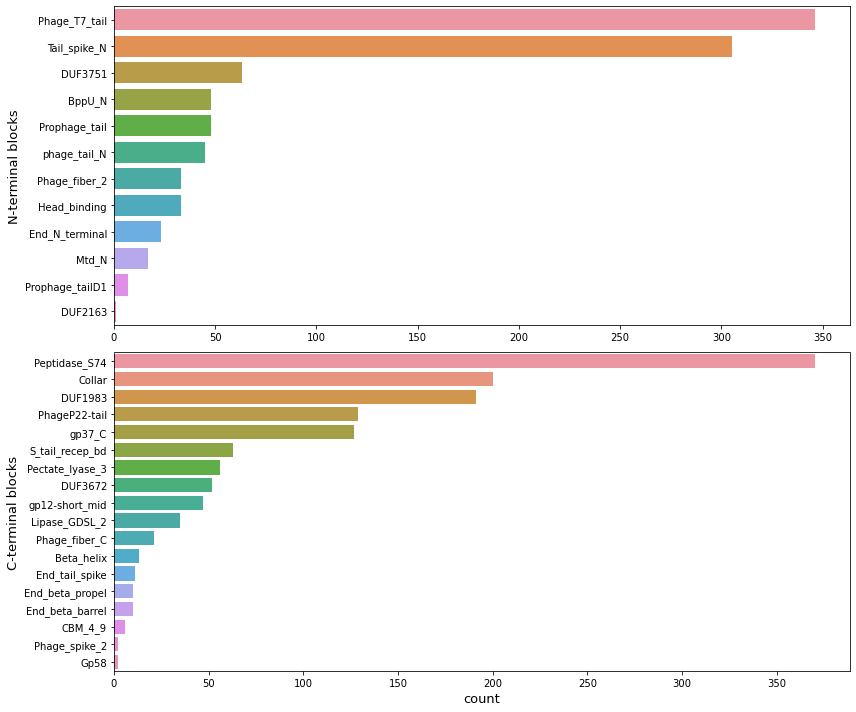

In [24]:
import seaborn as sns
N_blocks_long = []
C_blocks_long = []
for i, N_block in enumerate(detected_rbps['N_blocks']):
    for Nb in N_block:
        N_blocks_long.append(Nb)
    for Cb in detected_rbps['C_blocks'][i]:
        C_blocks_long.append(Cb)

Nb_df = pd.DataFrame({'N-terminal blocks':N_blocks_long})
Cb_df = pd.DataFrame({'C-terminal blocks':C_blocks_long})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))
c1 = sns.countplot(y='N-terminal blocks', data=Nb_df, order=Nb_df['N-terminal blocks'].value_counts().index, ax=ax1)
c2 = sns.countplot(y='C-terminal blocks', data=Cb_df, order=Cb_df['C-terminal blocks'].value_counts().index, ax=ax2)
ax1.set_xlabel('', size=13)
ax2.set_xlabel('count', size=13)
ax1.set_ylabel('N-terminal blocks', size=13)
ax2.set_ylabel('C-terminal blocks', size=13)
fig.tight_layout()
fig.savefig(results_dir+'/Figure3_domains_counts.png', dpi=400)
#fig.savefig(results_dir+'/domains_count_plot.svg')

In [16]:
label_dict_new = {'N-terminal anchor': ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
                                        'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 
                                        'Prophage_tailD1', 'DUF2163', 'Phage_fiber_2'],
                 'Enzymatic domain': ['Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
                                       'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
                                       'gp12-short_mid', 'Collar'],
                 'C-terminal binding or chaperone': ['S_tail_recep_bd', 'Peptidase_S74', 'Phage_fiber_C',
                                                    'CBM_4_9', 'DUF1983', 'DUF3672']}

/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/ipykernel_8190/1818076759.py:98: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


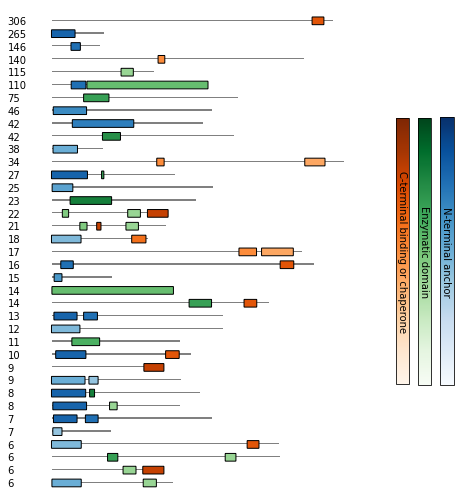

In [17]:
proteins = [str(Seq(dnaseq).translate())[:-1] for dnaseq in detected_rbps.DNASeq]
domains = [detected_rbps.N_blocks[i]+detected_rbps.C_blocks[i] for i in range(detected_rbps.shape[0])]
locations = [detected_rbps.N_ranges[i]+detected_rbps.C_ranges[i] for i in range(detected_rbps.shape[0])]
sorted_combos = rbpu.protein_architecture_plot(proteins, domains, locations, label_dict=label_dict_new, count_threshold=5, save_fig=True)

#### Build custom domains for unknown parts of detected sequences

In [9]:
rbpu.build_custom_HMMs(detected_rbps, data_dir, cdpath, hmm_path)

Checking unknown sequences...
Clustering with CD-HIT...
Building MSAs...
Building HMMs...
Done.


#### Add domains to the Pfam file for new detections

Manual step: adding all the different custom-built HMMs to the Pfam file. Easiest thing to do is to copy the Pfam database, add all the files, delete all the previous Pfam database related files (.h3i, .h3f, etc..) and press the new database again.

In [214]:
new_pfam_file = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A_new.hmm'
output, err = rbpu.hmmpress_python(hmm_path, new_pfam_file)

In [225]:
new_N_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
           'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
           'DUF2163', 'Phage_fiber_2', 'unknown_N0', 'unknown_N1', 'unknown_N2', 'unknown_N3', 'unknown_N4', 
            'unknown_N6', 'unknown_N10', 'unknown_N11', 'unknown_N12', 'unknown_N13', 'unknown_N17', 'unknown_N19', 
            'unknown_N23', 'unknown_N24', 'unknown_N26','unknown_N29', 'unknown_N36', 'unknown_N45', 'unknown_N48', 
            'unknown_N49', 'unknown_N53', 'unknown_N57', 'unknown_N60', 'unknown_N61', 'unknown_N65', 'unknown_N73', 
            'unknown_N82', 'unknown_N83', 'unknown_N101', 'unknown_N114', 'unknown_N119', 'unknown_N122', 
            'unknown_N163', 'unknown_N174', 'unknown_N192', 'unknown_N200', 'unknown_N206', 'unknown_N208']
new_C_blocks = ['Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
            'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
            'gp12-short_mid', 'Collar', 
            'unknown_C2', 'unknown_C3', 'unknown_C8', 'unknown_C15', 'unknown_C35', 'unknown_C54', 'unknown_C76', 
            'unknown_C100', 'unknown_C105', 'unknown_C112', 'unknown_C123', 'unknown_C179', 'unknown_C201', 
            'unknown_C203', 'unknown_C228', 'unknown_C234', 'unknown_C242', 'unknown_C258', 'unknown_C262', 
            'unknown_C267', 'unknown_C268', 'unknown_C274', 'unknown_C286', 'unknown_C292', 'unknown_C294', 
            'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

new_pfam_file = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A_new.hmm'

new_detected_rbps = rbpu.RBPdetect_domains(hmm_path, new_pfam_file, rbps_upto2021['DNASeq'], rbps_upto2021['protein_id'],
                                       N_blocks=new_N_blocks, C_blocks=new_C_blocks, detect_others=False)

Scanning the genes:   0%|          | 0/4189 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [226]:
new_detected_rbps

,identifier,DNASeq,N_blocks,C_blocks,N_ranges,C_ranges
0,QYC51048.1,ATGAGTAACAATACAATCAACCACGTAAGTGATAAATCCATTTACG...,"[unknown_N0, unknown_N4, unknown_N83]",[Collar],"[(0, 200), (0, 193), (0, 202)]","[(314, 369)]"
1,QYC51112.1,ATGGCTGATTTAGAAAAAATTCAATTCCTACGTAGCACAGTTGCGG...,"[unknown_N1, unknown_N24, unknown_N6, unknown_...",[Peptidase_S74],"[(0, 199), (0, 86), (0, 65), (0, 50)]","[(1176, 1229)]"
2,QXV72116.1,ATGACCATTATCAAACGCGCAGACCTGGGTCGGCCCTTAACGTGGG...,[Tail_spike_N],[],"[(88, 130)]",[]
3,QIW90047.1,ATGAGCACGAAATTTAAAACCGTTATCACTACTGCCGGAGCCGCGA...,"[Phage_fiber_2, DUF3751]",[],"[(169, 210), (0, 151)]",[]
4,UAW53860.1,ATGGCCCAGGTCCCTATCGTAGAGGACAACCACACGGGCGATGGCG...,[Phage_T7_tail],[],"[(0, 106)]",[]
...,...,...,...,...,...,...
2382,BAF43880.1,ATGTACAAAATAAAAGATGTTGAAACGAGAATAAAAAATGATGGTG...,[BppU_N],[unknown_C258],"[(3, 143)]","[(143, 412)]"
2383,BAF63353.1,ATGGACGTTGAGTACGGTCAGTACAGCGTTATTCTGTTGGTGGAGG...,[phage_tail_N],[Phage_fiber_C],"[(0, 83)]","[(312, 376)]"
2384,ACJ10189.1,ATGTCAAAAATTATCCCCAATATTGTCGTGAGTATGCCCACTCAGT...,[Head_binding],[unknown_C268],"[(0, 113)]","[(48, 77)]"
2385,BAF98834.1,ATGAGCCAGACGGCCATTCCACTGCAGTTTGAAAAGTACCTGCAAA...,[DUF3751],[],"[(3, 153)]",[]


## 3. Learning patterns and evaluating models

Here, we build an XGBoost classifier to discriminate between phage RBPs and phage nonRBPs, as defined in the processing above. We train our model on all data before October 2021. This allows for a separate and final benchmark against PhANNs using the sequence data that only became available during the last three months of 2021. Therefore, the embeddings that were computed in the cloud also include the record data of each corresponding data point. Then we split according to this date.

Findings:
- we see that standard scaling does not affect peformance.
- the One-class approaches don't seem to work, at least not at a split of 1:10. Perhaps the high dimensionality is also a problem...
- The XGBoost classifier seems to work best so far.
- The AUC metric considers both the majority and minority class, which can give an overly optimistic estimate of performance. The F1 score considers only the positive/minority class.

#### Load processed data  & filter up to SEP 2021

In [7]:
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if any(x in date for x in months)]
rbps_upto2021 = rbps_em.drop(to_delete_rbps)
rbps_upto2021 = rbps_upto2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if any(x in date for x in months)]
nonrbps_upto2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_upto2021 = nonrbps_upto2021.reset_index(drop=True)

rbp_embed = np.asarray(rbps_upto2021.iloc[:, 2:])
nonrbp_embed = np.asarray(nonrbps_upto2021.iloc[:, 2:])

features = np.concatenate((rbp_embed, nonrbp_embed))
labels = np.asarray([1]*rbp_embed.shape[0] + [0]*nonrbp_embed.shape[0])
print('Check?', features.shape[0]==labels.shape[0])
print('Check?', features.shape[1]==1024)

Check? True
Check? True


In [7]:
rbps_upto2021.shape

(4189, 1026)

In [8]:
nonrbps_upto2021.shape

(37022, 1026)

#### Explore the embeddings with PCA & tSNE

In [8]:
# PCA to visualize class separation
pca = PCA(n_components=5)
fr_pca = pca.fit_transform(features)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

tsne = TSNE(n_components=3)
fr_tsne = tsne.fit_transform(features)

[0.21927851 0.16474411 0.13806368 0.0748293  0.0392286 ] 0.6361441929162012


/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


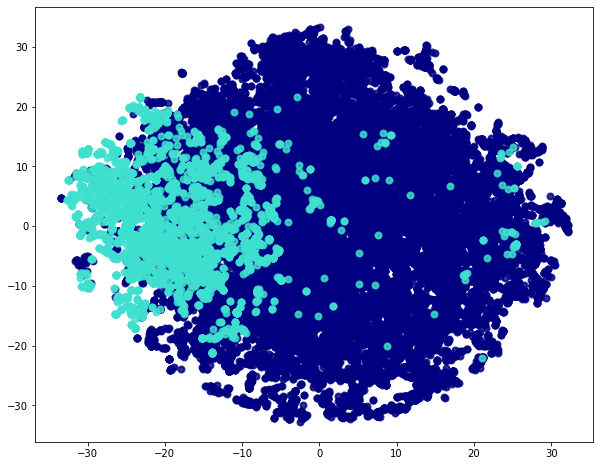

In [9]:
fr = fr_tsne
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["navy", "turquoise"]
for color, i in zip(colors, [0, 1]):
    ax.scatter(fr[labels == i, 0], fr[labels == i, 1], color=color, alpha=0.8, lw=2)

#### Nested cross-validation: optimize hyperparameters and evaluate model performance

In [18]:
# define cross-validation iterator & models
imbalance = rbp_embed.shape[0]/nonrbp_embed.shape[0]
inner_cv = StratifiedKFold(n_splits=2, shuffle=True)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True)
performances = {'F1':[], 'P':[], 'AUC':[]}
cpus = 6

xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus, use_label_encoder=False)
params_xgb = {'max_depth': [3, 5], 'n_estimators': [250, 500]}

In [19]:
probabilities = np.zeros((features.shape[0], 2))
preds = np.zeros(features.shape[0])
bar = tqdm(total=4, desc='4-fold CV')

# define outer loop
for train_outer, test_outer in outer_cv.split(features, labels):
    X_train, X_test = features[train_outer], features[test_outer]
    y_train, y_test = labels[train_outer], labels[test_outer]

    # define inner loop (in GridSearchCV)
    tuned_xgb = GridSearchCV(xgb, cv=inner_cv, param_grid=params_xgb, scoring='f1')
    tuned_xgb.fit(X_train, y_train, eval_metric='logloss')
    print(tuned_xgb.best_params_)

    # make predictions for test set (outer loop)
    y_probs = tuned_xgb.predict_proba(X_test)
    y_preds = tuned_xgb.predict(X_test)

    # store predictions at the corresponding locations
    for i, index in enumerate(test_outer):
        probabilities[index,:] = y_probs[i,:]
        preds[index] = y_preds[i]
        
    bar.update(1)
bar.close()

4-fold CV:   0%|          | 0/4 [00:00<?, ?it/s]

{'max_depth': 5, 'n_estimators': 250}
{'max_depth': 3, 'n_estimators': 500}
{'max_depth': 3, 'n_estimators': 500}
{'max_depth': 5, 'n_estimators': 500}


In [26]:
precision, recall, thresholds = precision_recall_curve(labels, probabilities[:,1])
print('F1:', f1_score(labels, preds))
print('PRAUC:', round(auc(recall, precision), 3))

F1: 0.8856510082760228
PRAUC: 0.938


In [28]:
# store predictions for further use (PR curves & PRAUC)
xgb_results = pd.concat([pd.DataFrame(preds, columns=['Predictions']), 
                        pd.DataFrame(probabilities[:,1], columns=['Score_pos'])], axis=1)
xgb_results.to_csv(results_dir+'/xgboost_4foldCV_results.csv', index=False)

In [31]:
# train model with best params on all data
xgb_all = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus, use_label_encoder=False, 
                        max_depth=3, n_estimators=500)
xgb_all.fit(features, labels, eval_metric='logloss')

# save model for later benchmark with phANNs
xgb_all.save_model(results_dir+'/RBPdetect_xgb_model.json')

## 4. Benchmarking domain-based approach, ML-based approach and PhANNs

In [12]:
# load data and select 2021 (oct-nov-dec) data as test set
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if all(x not in date for x in months)]
rbps_2021 = rbps_em.drop(to_delete_rbps)
rbps_2021 = rbps_2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if all(x not in date for x in months)]
nonrbps_2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_2021 = nonrbps_2021.reset_index(drop=True)
testdata = pd.concat([rbps_2021, nonrbps_2021], axis=0)
print('Check?', testdata.shape[0]==(rbps_2021.shape[0]+nonrbps_2021.shape[0]))

# features for our XGBoost model
testfeatures = np.asarray(testdata.iloc[:, 2:])
testlabels = np.asarray([1]*rbps_2021.shape[0] + [0]*nonrbps_2021.shape[0])

# sequence DF for PhANNs
rbps = pd.read_csv(data_dir+'/annotated_RBPs_2022-01.csv')
nonrbps = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01.csv')
rbps_2021 = rbps.drop(to_delete_rbps)
nonrbps_2021_ids = list(nonrbps_2021['protein_id'])
to_delete_nonrbps = [i for i, pid in enumerate(nonrbps['protein_id']) if pid not in nonrbps_2021_ids]
nonrbps_2021 = nonrbps.drop(to_delete_nonrbps)
testdata_df = pd.concat([rbps_2021, nonrbps_2021], axis=0)
testdata_df = testdata_df.reset_index(drop=True)
print('Check?', testdata.shape[0]==testdata_df.shape[0])

Check? True
Check? True


In [5]:
rbps_2021.shape

(1987, 8)

In [6]:
nonrbps_2021.shape

(24738, 8)

In [12]:
testdata_df

,phage_id,protein_id,Organism,Host,ProteinName,ProteinSeq,DNASeq,RecordDate
0,OL441337,UFK26514.1,Pseudomonas phage PaP_Se,Pseudomonas aeruginosa,tail fibers protein,MGLEVATYINQLVPTNPTGSDLKSFGDDHLRLIKSAIKNTFPNISQ...,ATGGGTCTTGAGGTCGCAACTTATATTAACCAGTTGGTGCCTACGA...,28-NOV-2021
1,OK625527,UFK26377.1,Klebsiella phage vB_KpnP_ZK1,Klebsiella pneumoniae,tail fibers protein,MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPG...,ATGGAAGTTCAAGGCTCGTTAGGTCGGCAGATACAAGGTATCAGCC...,28-NOV-2021
2,OK562429,UFJ83549.1,Klebsiella phage P929,Klebsiella pneumoniae Kp325,non-contractile tail fiber protein,MAFSWQEQIKPAGTQDIQCDIEYLDKSYIHVYLDGEETTGYTWTSS...,ATGGCGTTCAGCTGGCAAGAACAAATCAAGCCAGCTGGTACCCAGG...,28-NOV-2021
3,OK546191,UFJ83440.1,Acinetobacter phage vB_AbaP_ABWU2101,Acinetobacter baumannii,tailspike protein,MNILRSFTETVVTTPTELFPISFEYDEKYDAVHVFLNDVAVEDLGY...,ATGAATATACTACGCTCATTTACAGAGACAGTGGTGACTACACCTA...,28-NOV-2021
4,MZ675741,UFJ83225.1,Acinetobacter phage Ab1656-2,Acinetobacter baumannii 1656-2,putative tail fiber,MANLVFKFSWDHRPFPYNASQGKRQFMLPFASGIPNLAPNFSQVVG...,ATGGCAAATCTTGTTTTTAAATTTAGTTGGGATCATCGGCCATTCC...,28-NOV-2021
...,...,...,...,...,...,...,...,...
26720,MZ514874,QZI85268.1,Acinetobacter phage Ab105-2phideltaCI404ad,Acinetobacter baumannii Ab404_GEIH-2010,coat protein,MGDTKIADVIVPELFTPYVLNKTAEKSALWQSGIVGELDEKVAFGT...,ATGGGCGACACAAAAATTGCTGATGTAATCGTACCCGAGTTATTCA...,30-NOV-2021
26721,MZ514874,QZI85283.1,Acinetobacter phage Ab105-2phideltaCI404ad,Acinetobacter baumannii Ab404_GEIH-2010,DUF4468 domain-containing protein,MKKILAAGLIGFGLVGCATTPQQPSEPVKFEKVYQIDGLKQGQIYD...,ATGAAAAAAATATTGGCTGCTGGATTAATCGGTTTTGGGTTAGTTG...,30-NOV-2021
26722,MZ514874,QZI85288.1,Acinetobacter phage Ab105-2phideltaCI404ad,Acinetobacter baumannii Ab404_GEIH-2010,Rha family transcriptional regulator,MNMMSVLNLRAVVTQENGEVKTTSYAVAEAFDKLHKNVIRDIEKLR...,ATGAATATGATGTCAGTATTAAACTTAAGAGCTGTTGTTACACAGG...,30-NOV-2021
26723,MZ514874,QZI85300.1,Acinetobacter phage Ab105-2phideltaCI404ad,Acinetobacter baumannii Ab404_GEIH-2010,"BRO family, N-terminal domain protein",MSSLALSFNEVKFNPVVRDNGQIYLTAGELAQALDYKSVKSVSNLY...,ATGTCTAGTTTAGCATTAAGCTTTAACGAAGTGAAATTTAACCCGG...,30-NOV-2021


#### Predictions with protein domains

Make sure the extended Pfam HMM database is pressed first, otherwise detection won't work.

In [5]:
N_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
           'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
           'DUF2163', 'Phage_fiber_2', 'unknown_N0', 'unknown_N1', 'unknown_N2', 'unknown_N3', 'unknown_N4', 
            'unknown_N6', 'unknown_N10', 'unknown_N11', 'unknown_N12', 'unknown_N13', 'unknown_N17', 'unknown_N19', 
            'unknown_N23', 'unknown_N24', 'unknown_N26','unknown_N29', 'unknown_N36', 'unknown_N45', 'unknown_N48', 
            'unknown_N49', 'unknown_N53', 'unknown_N57', 'unknown_N60', 'unknown_N61', 'unknown_N65', 'unknown_N73', 
            'unknown_N82', 'unknown_N83', 'unknown_N101', 'unknown_N114', 'unknown_N119', 'unknown_N122', 
            'unknown_N163', 'unknown_N174', 'unknown_N192', 'unknown_N200', 'unknown_N206', 'unknown_N208']
C_blocks = ['Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
            'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
            'gp12-short_mid', 'Collar', 
            'unknown_C2', 'unknown_C3', 'unknown_C8', 'unknown_C15', 'unknown_C35', 'unknown_C54', 'unknown_C76', 
            'unknown_C100', 'unknown_C105', 'unknown_C112', 'unknown_C123', 'unknown_C179', 'unknown_C201', 
            'unknown_C203', 'unknown_C228', 'unknown_C234', 'unknown_C242', 'unknown_C258', 'unknown_C262', 
            'unknown_C267', 'unknown_C268', 'unknown_C274', 'unknown_C286', 'unknown_C292', 'unknown_C294', 
            'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']
new_pfam_file = '/Users/Dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/Pfam-A_new.hmm'

In [6]:
detected = rbpu.RBPdetect_domains(hmm_path, new_pfam_file, testdata_df['DNASeq'], testdata_df['protein_id'], 
                                  N_blocks=N_blocks, C_blocks=C_blocks, detect_others=False)

Scanning the genes:   0%|          | 0/26725 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [7]:
detected

,identifier,DNASeq,N_blocks,C_blocks,N_ranges,C_ranges
0,UFK26514.1,ATGGGTCTTGAGGTCGCAACTTATATTAACCAGTTGGTGCCTACGA...,[unknown_N48],[],"[(20, 90)]",[]
1,UFJ83549.1,ATGGCGTTCAGCTGGCAAGAACAAATCAAGCCAGCTGGTACCCAGG...,"[Phage_T7_tail, unknown_N2]","[unknown_C234, unknown_C76, unknown_C286]","[(13, 140), (10, 105)]","[(141, 306), (131, 281), (26, 36)]"
2,UFJ83440.1,ATGAATATACTACGCTCATTTACAGAGACAGTGGTGACTACACCTA...,[unknown_N2],[Pectate_lyase_3],"[(0, 172)]","[(175, 382)]"
3,UFJ83225.1,ATGGCAAATCTTGTTTTTAAATTTAGTTGGGATCATCGGCCATTCC...,[unknown_N29],[],"[(47, 68)]",[]
4,YP_009966145.1,ATGGCTGATACAACACAATTTGAACAGGCTGTGGATCAGGTTATCG...,[],[unknown_C123],[],"[(64, 115)]"
...,...,...,...,...,...,...
1676,YP_009217703.1,ATGCCAATTATACTATCGGTGAGTAAGGGAAGTCCCCTTACTTGTG...,[unknown_N48],[Collar],"[(56, 104)]","[(224, 276)]"
1677,YP_009042668.1,ATGGCAGTAATTAAATCAGAATACCTACTTTCAAATTATGACCCAG...,[],[unknown_C3],[],"[(19, 81)]"
1678,YP_009042547.1,ATGGCATCAGAAGAAATTAAAAAGACCGCTGTCATTAACATGTATG...,[BppU_N],[],"[(23, 166)]",[]
1679,YP_007392815.1,ATGAGTTTTAACAGCCGCGAAAGCTCGCTCGCGGATGGGCAGCCGG...,[DUF2163],[],"[(13, 159)]",[]


In [10]:
domain_preds = []
for pid in list(testdata_df['protein_id']):
    if pid in list(detected['identifier']):
        domain_preds.append(1)
    else:
        domain_preds.append(0)
domain_results = pd.DataFrame(domain_preds, columns=['preds'])
domain_results.to_csv(results_dir+'/domains_test_predictions.csv', index=False)

#### Predictions with XGBoost

In [50]:
# load model again
xgb_saved = XGBClassifier()
xgb_saved.load_model(results_dir+'/RBPdetect_xgb_model.json')

# make predictions with the XGBoost model
score_xgb = xgb_saved.predict_proba(testfeatures)[:,1]
preds_xgb = (score_xgb > 0.5)*1

# save predictions and scores
xgb_results = pd.concat([pd.DataFrame(preds_xgb, columns=['preds']), 
                        pd.DataFrame(score_xgb, columns=['score'])], axis=1)
xgb_results.to_csv(results_dir+'/xgboost_test_predictions.csv', index=False)

#### Predictions with PhANNs

It is estimated that this will run for about a day (24 hours), depending on your computer specs.

In [14]:
count = 0
for i in tqdm(range(0, testdata_df.shape[0], 5000)):
    count += 1
    suff = '_part'+str(count)
    end = min(5000, testdata_df.shape[0]-i)
    rbpu.phanns_predict(testdata_df.iloc[i:i+end, :], phanns_dir, data_dir, suff)

  0%|          | 0/6 [00:00<?, ?it/s]

Getting results...
Done.
Getting results...
Done.
Getting results...
Done.
Getting results...
Done.
Getting results...
Done.
Getting results...
Done.


#### Comparison between methods

In [48]:
# load data
phanns_results = pd.DataFrame({}, columns=['preds', 'score'])
for i in range(1,7):
    part = pd.read_csv(data_dir+'/phanns_predictions_part'+str(i)+'.csv')
    phanns_results = pd.concat([phanns_results, part], axis=0)
    
domain_results = pd.read_csv(results_dir+'/domains_test_predictions.csv')
xgb_results = pd.read_csv(results_dir+'/xgboost_test_predictions.csv')

In [49]:
# compute performances
print('Scores domain-based method')
print('F1 score:', round(f1_score(testlabels, list(domain_results['preds'])), 4))
print('MCC score:', round(matthews_corrcoef(testlabels, list(domain_results['preds'])), 4))
tn, fp, fn, tp = confusion_matrix(testlabels, list(domain_results['preds'])).ravel()
print('Sensitivity:', round(tp/(tp+fn), 4))
print('Specificity:', round(tn/(tn+fp), 4))
print()
print('Scores PhANNs')
print('F1 score:', round(f1_score(testlabels, list(phanns_results['preds'])), 4))
print('MCC score:', round(matthews_corrcoef(testlabels, list(phanns_results['preds'])), 4))
tn, fp, fn, tp = confusion_matrix(testlabels, list(phanns_results['preds'])).ravel()
print('Sensitivity:', round(tp/(tp+fn), 4))
print('Specificity:', round(tn/(tn+fp), 4))
print()
print('Scores XGBoost')
print('F1 score:', round(f1_score(testlabels, list(xgb_results['preds'])), 4))
print('MCC score:', round(matthews_corrcoef(testlabels, list(xgb_results['preds'])), 4))
tn, fp, fn, tp = confusion_matrix(testlabels, list(xgb_results['preds'])).ravel()
print('Sensitivity:', round(tp/(tp+fn), 4))
print('Specificity:', round(tn/(tn+fp), 4))

Scores domain-based method
F1 score: 0.7197
MCC score: 0.7021
Sensitivity: 0.6643
Specificity: 0.9854

Scores PhANNs
F1 score: 0.6984
MCC score: 0.6788
Sensitivity: 0.8163
Specificity: 0.9581

Scores XGBoost
F1 score: 0.8403
MCC score: 0.8296
Sensitivity: 0.916
Specificity: 0.9788


In [13]:
# compute a venn diagram of the correct positive predictions
venn_1 = 0; venn_2 = 0; venn_3 = 0; venn_4 = 0; venn_5 = 0; venn_6 = 0; venn_7 = 0
db_preds = list(domain_results['preds']); phanns_preds = list(phanns_results['preds']); xgb_preds = list(xgb_results['preds'])
for i, label in enumerate(testlabels):
    if (label==1) and (db_preds[i]==1) and (phanns_preds[i]==0) and (xgb_preds[i]==0): # only domains correct
        venn_1 += 1
    elif (label==1) and (phanns_preds[i]==1) and (db_preds[i]==0) and (xgb_preds[i]==0): # only PhANNs correct
        venn_2 += 1
    elif (label==1) and (db_preds[i]==1) and (phanns_preds[i]==1) and (xgb_preds[i]==0): # domains and PhANNs correct
        venn_3 += 1
    elif (label==1) and (xgb_preds[i]==1) and (db_preds[i]==0) and (phanns_preds[i]==0): # only xgb correct
        venn_4 += 1
    elif (label==1) and (db_preds[i]==1) and (xgb_preds[i]==1) and (phanns_preds[i]==0): # domains and xgb correct
        venn_5 += 1
    elif (label==1) and (phanns_preds[i]==1) and (xgb_preds[i]==1) and (db_preds[i]==0): # phanns and xgb correct
        venn_6 += 1
    elif (label==1) and (db_preds[i]==1) and (phanns_preds[i]==1) and (xgb_preds[i]==1): # all correct
        venn_7 += 1

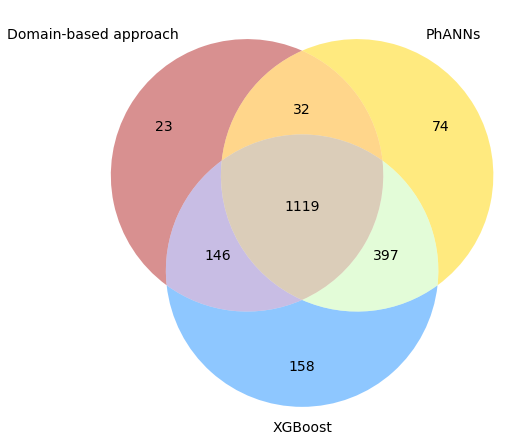

In [14]:
# make plot
colors = ('firebrick', 'gold', 'dodgerblue')
fig, ax = plt.subplots(figsize=(8,8))
vd = venn3_unweighted(subsets=(venn_1, venn_2, venn_3, venn_4, venn_5, venn_6, venn_7),
                 set_labels=('Domain-based approach', 'PhANNs', 'XGBoost'), 
                 alpha=0.5, ax=ax, set_colors=('firebrick', 'gold', 'dodgerblue'))
for text in vd.subset_labels:
    text.set_fontsize(14)
for text in vd.set_labels:
    text.set_fontsize(14)
fig.savefig(results_dir+'/benchmark_venn_correct_positives.png', dpi=400)
#fig.savefig('/Users/Dimi/Documents/GitHub/SYNTH_DRUG_DETECTION/results/venn_positives_eps.eps', dpi=400, format='eps', facecolor='w', edgecolor='none')

In [15]:
# The XGBoost classifiers misses fewer than 10% of the RBPs to be detected
(venn_4+venn_5+venn_6+venn_7)/sum(testlabels==1)

0.9159536990437847

In [16]:
# there are still a few instances that all of the methods miss (not many though)
sum(testlabels==1) == sum([venn_1, venn_2, venn_3, venn_4, venn_5, venn_6, venn_7])

False

If our goal is to further increase the performance of the XGBoost model, we can additionally look at things such as:
- Which 23+32 sequences were detected by the domains-based approach that were missed by XGBoost?
- What types of domains do we see in these 20+27 sequences and might those be underrepresented in the training data for the XGBoost classifier?
- What 74 sequences does PhANNs classify correctly that XGBoost classifier and domains miss?

## 5. Combining HMM scores and embeddings

#### Constructing HMM scores featureset

In [16]:
# load processed data
rbps = pd.read_csv(data_dir+'/annotated_RBPs_2022-01.csv')
nonrbps = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01.csv')

In [17]:
# load embeddings and filter
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if any(x in date for x in months)]
rbps_upto2021 = rbps_em.drop(to_delete_rbps)
rbps_upto2021 = rbps_upto2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if any(x in date for x in months)]
nonrbps_upto2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_upto2021 = nonrbps_upto2021.reset_index(drop=True)

rbp_embed = np.asarray(rbps_upto2021.iloc[:, 2:])
nonrbp_embed = np.asarray(nonrbps_upto2021.iloc[:, 2:])

features = np.concatenate((rbp_embed, nonrbp_embed))
labels = np.asarray([1]*rbp_embed.shape[0] + [0]*nonrbp_embed.shape[0])
print('Check?', features.shape[0]==labels.shape[0])
print('Check?', features.shape[1]==1024)

Check? True
Check? True


In [19]:
# get all sequences to compute HMM scores for
sequences = []
for protein_id in rbps_upto2021['protein_id']:
    index = rbps.index[rbps['protein_id'] == protein_id][0]
    sequences.append(rbps['DNASeq'][index])
for protein_id in nonrbps_upto2021['protein_id']:
    index = nonrbps.index[nonrbps['protein_id'] == protein_id][0]
    sequences.append(nonrbps['DNASeq'][index])

In [39]:
# define all the blocks we want scores for
new_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
           'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
           'DUF2163', 'Phage_fiber_2', 'unknown_N0', 'unknown_N1', 'unknown_N2', 'unknown_N3', 'unknown_N4', 
            'unknown_N6', 'unknown_N10', 'unknown_N11', 'unknown_N12', 'unknown_N13', 'unknown_N17', 'unknown_N19', 
            'unknown_N23', 'unknown_N24', 'unknown_N26','unknown_N29', 'unknown_N36', 'unknown_N45', 'unknown_N48', 
            'unknown_N49', 'unknown_N53', 'unknown_N57', 'unknown_N60', 'unknown_N61', 'unknown_N65', 'unknown_N73', 
            'unknown_N82', 'unknown_N83', 'unknown_N101', 'unknown_N114', 'unknown_N119', 'unknown_N122', 
            'unknown_N163', 'unknown_N174', 'unknown_N192', 'unknown_N200', 'unknown_N206', 'unknown_N208', 
            'Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
            'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
            'gp12-short_mid', 'Collar', 
            'unknown_C2', 'unknown_C3', 'unknown_C8', 'unknown_C15', 'unknown_C35', 'unknown_C54', 'unknown_C76', 
            'unknown_C100', 'unknown_C105', 'unknown_C112', 'unknown_C123', 'unknown_C179', 'unknown_C201', 
            'unknown_C203', 'unknown_C228', 'unknown_C234', 'unknown_C242', 'unknown_C258', 'unknown_C262', 
            'unknown_C267', 'unknown_C268', 'unknown_C274', 'unknown_C286', 'unknown_C292', 'unknown_C294', 
            'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

# make dictionary for scores
hmm_scores = {item:[0]*len(sequences) for item in new_blocks}

In [47]:
# get domains & scores (press HMM data first!)
bar = tqdm(total=len(sequences), desc='Scanning the genes', position=0, leave=True)
small_pfam_file = '/Users/Dimi/Documents/GitHub/PhageRBPdetection/data/RBPdetect_phageRBPs.hmm'
for i, sequence in enumerate(sequences):
    hits, scores, biases, ranges = rbpu.gene_domain_scan(hmm_path, small_pfam_file, [sequence])
    for j, dom in enumerate(hits):
        hmm_scores[dom][i] = scores[j]
    bar.update(1)
bar.close()
hmm_scores_array = np.asarray(pd.DataFrame(hmm_scores))
print('Check?', hmm_scores_array.shape[0]==labels.shape[0])
print('Check?', hmm_scores_array.shape[1]==len(new_blocks))

Scanning the genes:   0%|          | 0/41211 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Check? True
Check? True


In [54]:
features = np.concatenate((features, hmm_scores_array), axis=1)
print('Check?', features.shape[0]==labels.shape[0])

Check? True


#### Training XGBoost classifier on embeddings + HMM scores

In [57]:
# train model with best params on all data
imbalance = rbp_embed.shape[0]/nonrbp_embed.shape[0]

xgb_all = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=6, use_label_encoder=False, 
                        max_depth=3, n_estimators=500)
xgb_all.fit(features, labels, eval_metric='logloss')

# save model
xgb_all.save_model(results_dir+'/RBPdetect_xgb_model_HMMscores.json')

#### Making predictions and compare with initial XGBoost classifier

In [58]:
# load data and select 2021 (oct-nov-dec) data as test set
rbps_em = pd.read_csv(data_dir+'/annotated_RBPs_2022-01_embeddings.csv')
nonrbps_em = pd.read_csv(data_dir+'/annotated_nonRBPs_2022-01_embeddings.csv')
months = ['OCT-2021', 'NOV-2021', 'DEC-2021']
to_delete_rbps = [i for i, date in enumerate(rbps_em['RecordDate']) if all(x not in date for x in months)]
rbps_2021 = rbps_em.drop(to_delete_rbps)
rbps_2021 = rbps_2021.reset_index(drop=True)
to_delete_nonrbps = [i for i, date in enumerate(nonrbps_em['RecordDate']) if all(x not in date for x in months)]
nonrbps_2021 = nonrbps_em.drop(to_delete_nonrbps)
nonrbps_2021 = nonrbps_2021.reset_index(drop=True)
testdata = pd.concat([rbps_2021, nonrbps_2021], axis=0)
print('Check?', testdata.shape[0]==(rbps_2021.shape[0]+nonrbps_2021.shape[0]))

# features for our XGBoost model
testfeatures = np.asarray(testdata.iloc[:, 2:])
testlabels = np.asarray([1]*rbps_2021.shape[0] + [0]*nonrbps_2021.shape[0])

Check? True


In [59]:
# get all sequences to test
test_sequences = []
for protein_id in rbps_2021['protein_id']:
    index = rbps.index[rbps['protein_id'] == protein_id][0]
    test_sequences.append(rbps['DNASeq'][index])
for protein_id in nonrbps_2021['protein_id']:
    index = nonrbps.index[nonrbps['protein_id'] == protein_id][0]
    test_sequences.append(nonrbps['DNASeq'][index])

In [62]:
hmm_scores_test = {item:[0]*len(test_sequences) for item in new_blocks}

# get domains & scores (press HMM data first!)
bar = tqdm(total=len(test_sequences), desc='Scanning the genes', position=0, leave=True)
small_pfam_file = '/Users/Dimi/Documents/GitHub/PhageRBPdetection/data/RBPdetect_phageRBPs.hmm'
for i, sequence in enumerate(test_sequences):
    hits, scores, biases, ranges = rbpu.gene_domain_scan(hmm_path, small_pfam_file, [sequence])
    for j, dom in enumerate(hits):
        hmm_scores_test[dom][i] = scores[j]
    bar.update(1)
bar.close()
hmm_scores_testarr = np.asarray(pd.DataFrame(hmm_scores_test))
print('Check?', hmm_scores_testarr.shape[0]==testlabels.shape[0])
print('Check?', hmm_scores_testarr.shape[1]==len(new_blocks))

Scanning the genes:   0%|          | 0/26725 [00:00<?, ?it/s]

Check? True
Check? True


In [65]:
testfeatures = np.concatenate((testfeatures, hmm_scores_testarr), axis=1)
print('Check?', testfeatures.shape[0]==testlabels.shape[0])

Check? True


In [67]:
# load model again
xgb_saved = XGBClassifier()
xgb_saved.load_model(results_dir+'/RBPdetect_xgb_model_HMMscores.json')

# make predictions with the XGBoost model
score_xgb = xgb_saved.predict_proba(testfeatures)[:,1]
preds_xgb = (score_xgb > 0.5)*1

# save predictions and scores
xgb_results = pd.concat([pd.DataFrame(preds_xgb, columns=['preds']), 
                        pd.DataFrame(score_xgb, columns=['score'])], axis=1)
xgb_results.to_csv(results_dir+'/xgboost_HMMscores_test_predictions.csv', index=False)

In [50]:
xgb_results = pd.read_csv(results_dir+'/xgboost_HMMscores_test_predictions.csv')
print('Scores XGBoost')
print('F1 score:', round(f1_score(testlabels, list(xgb_results['preds'])), 4))
print('MCC score:', round(matthews_corrcoef(testlabels, list(xgb_results['preds'])), 4))
tn, fp, fn, tp = confusion_matrix(testlabels, list(xgb_results['preds'])).ravel()
print('Sensitivity:', round(tp/(tp+fn), 4))
print('Specificity:', round(tn/(tn+fp), 4))

Scores XGBoost
F1 score: 0.8483
MCC score: 0.8382
Sensitivity: 0.9215
Specificity: 0.9798


Enhancing the protein embeddings with scores of our HMM collection results in an increase in F1-score of 0.8% on the independent test set, indicating that the protein embeddings by themselves already capture the information captured by the HMMs well.

## 6 - Extra

In [ ]:
# Histogram of alignments scores within training set and between training and test set
train_scores = np.loadtxt('/Users/Dimi/Desktop/rbps_training_score_matrix.txt')
test_scores = np.loadtxt('/Users/Dimi/Desktop/rbps_traintest_score_matrix.txt')

train_scores_list = []
for i in range(0, train_scores.shape[0]-1):
    for j in range(i+1, train_scores.shape[0]):
        train_scores_list.append(train_scores[i,j])
test_scores_list = list(np.ndarray.flatten(test_scores))     

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(train_scores_list, bins=500, color='darkorange', label='alignment scores within training set')
ax.hist(test_scores_list, bins=500, color='dodgerblue', label='alignment scores between training and test set')
ax.legend()
ax.set_xlabel('percentage identity')
ax.set_ylabel('count')